In [2]:
meal_data = read.csv("meal_orders.csv")

In [47]:
library(dplyr)
library(tidyverse)
library(fpp2) 

if (!require(dplyr)) install.packages("dplyr")
library(dplyr)
if (!require(forecast)) install.packages("forecast")
library(forecast)
if (!require(TTR)) install.packages("TTR")
library(TTR)
if (!require(TTR)) install.packages("ggplot2")
library(ggplot2)
if (!require(TTR)) install.packages("RColorBrewer")
library(RColorBrewer)

Loading required package: TTR

Warning message:
"package 'TTR' was built under R version 4.3.3"


In [50]:
plot_forecast <- function(model, graph_title){
  autoplot(model, PI = FALSE) +
  geom_line(aes(x = time(model$fitted), y=model$fitted, color = "Forecast")) +
  geom_line(aes(x = time(model$x), y=model$x, color = "Actual Demand")) +
  labs(title = graph_title,
       x = "Week Number",
       y = "Meal Count",
       fill = "Confidence Interval",
       color = "Lines") +
  geom_ribbon(aes(x = time(model$upper[, "95%"]), 
                  ymin = model$lower[, "95%"], 
                  ymax = model$upper[, "95%"], 
                  fill = "95%"), alpha = 0.2) +
  geom_ribbon(aes(x = time(model$upper[, "80%"]), 
                  ymin = model$lower[, "80%"], 
                  ymax = model$upper[, "80%"], 
                  fill = "80%"), alpha = 0.4) +
  scale_color_brewer(palette = "Dark2", name = "Lines") +
  scale_fill_brewer(palette = "Dark2", name = "Confidence Interval") 
}

In [3]:
head(meal_data)

,id,week,center_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,meal_id,category,cuisine,city_code,region_code,center_type,op_area
,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<chr>,<chr>,<int>,<int>,<chr>,<dbl>
1,1033240,109,10,583.00,584.00,0,0,485,2956,Fish,Continental,590,56,TYPE_B,6.3
2,1264380,108,10,670.33,670.33,0,0,94,2867,Seafood,Continental,590,56,TYPE_B,6.3
3,1133093,115,10,687.73,689.73,0,0,161,2867,Seafood,Continental,590,56,TYPE_B,6.3
4,1329545,63,10,618.89,617.89,0,0,80,2867,Seafood,Continental,590,56,TYPE_B,6.3
5,1249888,131,10,727.53,727.53,0,0,82,2867,Seafood,Continental,590,56,TYPE_B,6.3
6,1177302,65,10,485.03,609.19,1,1,460,2867,Seafood,Continental,590,56,TYPE_B,6.3


In [5]:
length(unique(meal_data$meal_id))
length(unique(meal_data$center_id))

[1] 51

[1] 77

In [13]:
unique(meal_data$center_id)

[1]  10  11  13  14  17  20  23  24  26  27  29  30  32  34  36  39  41  42  43
[20]  50  51  52  53  55  57  58  59  61  64  65  66  67  68  72  73  74  75  76
[39]  77  80  81  83  86  88  89  91  92  93  94  97  99 101 102 104 106 108 109
[58] 110 113 124 126 129 132 137 139 143 145 146 149 152 153 157 161 162 174 177
[77] 186

In [25]:
df_2 = filter(meal_data,meal_data$meal_id==2290 & meal_data$center_id==13)
nrow(df_2)

[1] 145

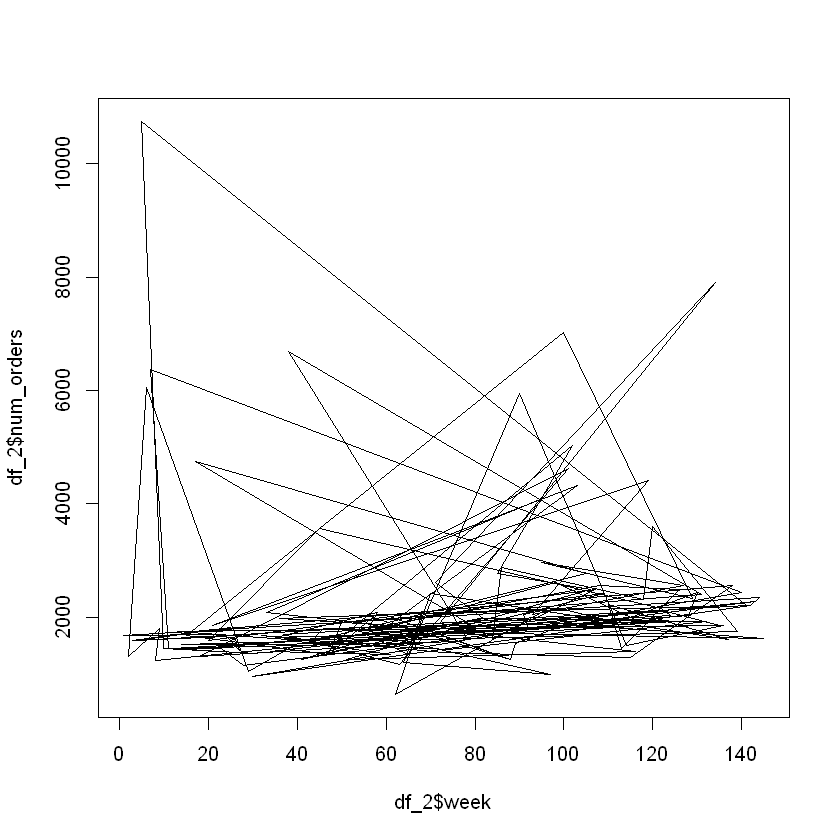

In [27]:
plot(df_2$week,df_2$num_orders, type='l')

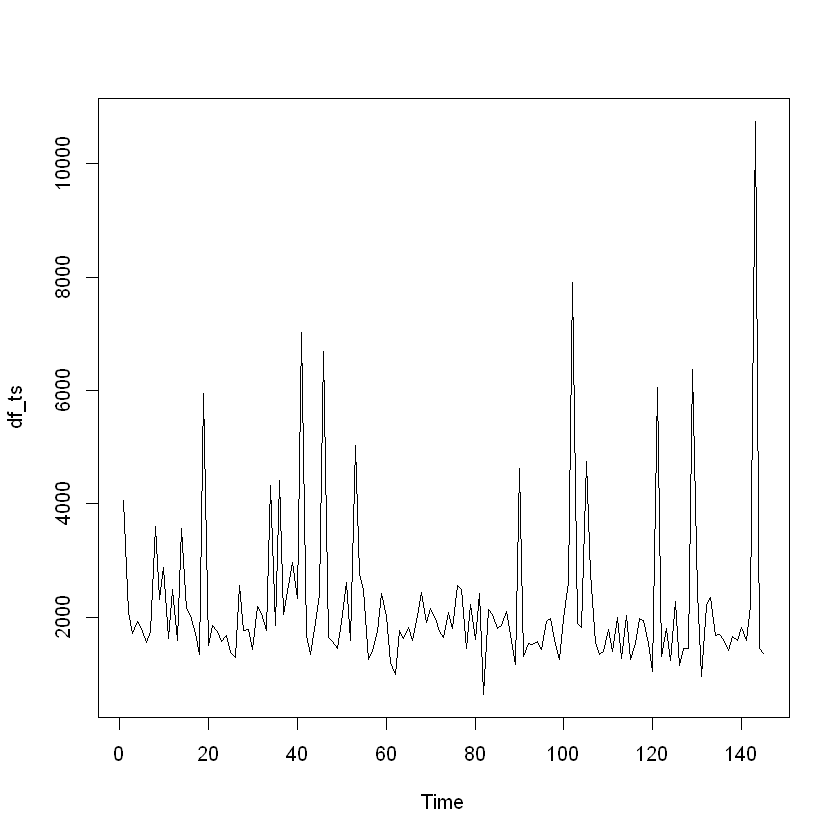

In [28]:
df_ts = ts(df_2$num_orders)
plot.ts(df_ts)

In [33]:
train = filter(df_2,df_2$week<=130)%>%arrange(week)
test = filter(df_2,df_2$week>130)%>%arrange(week)

Simple Exp. Smoothing


Simple exponential smoothing 

Call:
ses(y = train$num_orders, h = 15, initial = "simple")

  Smoothing parameters:
    alpha = 0.1761 

  Initial states:
    l = 1688 

  sigma:  1369.085

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,27.52244,1369.085,775.0868,-16.609717,34.28322,1.0228244,0.23592
Test set,159.62127,1489.884,649.5485,-7.817155,19.79442,0.8571608,NA


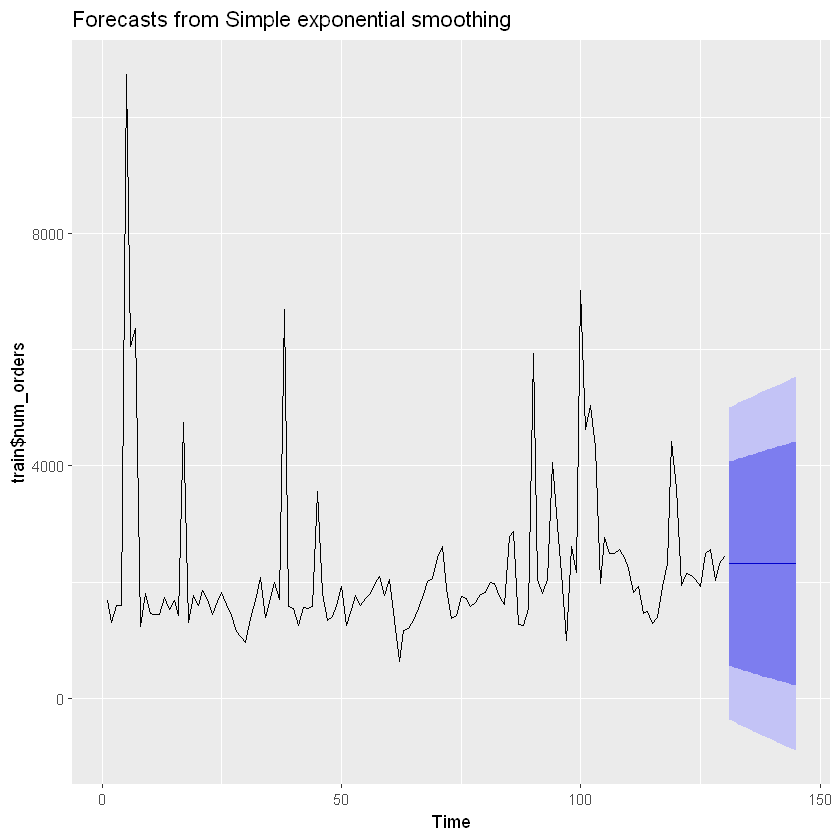

In [37]:
meal_ses = ses(train$num_orders, h = 15,initial = "simple")
meal_ses$model

autoplot(meal_ses)

accuracy(meal_ses,test$num_orders)

Holt Winters - Ex Smoothing with trend

Holt's method 

Call:
holt(y = train$num_orders, h = 15)

  Smoothing parameters:
    alpha = 0.1411 
    beta  = 1e-04 

  Initial states:
    l = 3376.7538 
    b = -6.4457 

  sigma:  1378.741

     AIC     AICc      BIC 
2518.237 2518.721 2532.575 

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,-10.2863,1357.364,817.6050,-19.046993,37.46514,1.0789325,0.2407986
Test set,247.5418,1495.404,630.2719,-3.662076,18.26638,0.8317229,NA


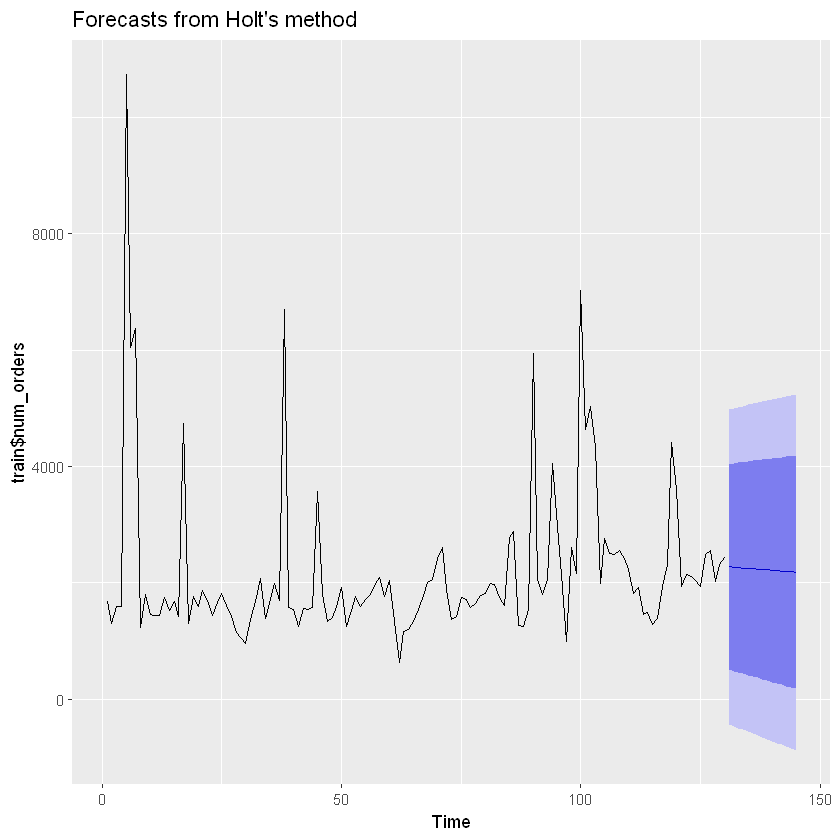

In [36]:
meal_holt = holt(train$num_orders,h=15)
meal_holt$model

autoplot(meal_holt)

accuracy(meal_holt,test$num_orders)

## ETS - error, trend, smoothing

In the `ses()` function `h=` the number of periods after the last known demand we want to forecast.

Check Residuals Output:

-   Auto-Correlation Function (ACF): Checks if there is correlation between the residuals at time n and time n+1.
    If there is no correlation, then the model is a good fit for the data.

-   Residuals histogram: Discloses the distribution of the residuals.

-   Line chart: Discloses the standardized residuals between the model and the data.

ETS(A,N,N) 

Call:
ets(y = df_2$num_orders)

  Smoothing parameters:
    alpha = 1e-04 

  Initial states:
    l = 2204.8219 

  sigma:  1392.039

     AIC     AICc      BIC 
2824.785 2824.955 2833.715 

Training set error measures:
                     ME     RMSE      MAE       MPE     MAPE      MASE
Training set -0.3244373 1382.405 812.7893 -20.98107 36.51008 0.7148019
                    ACF1
Training set -0.04874648

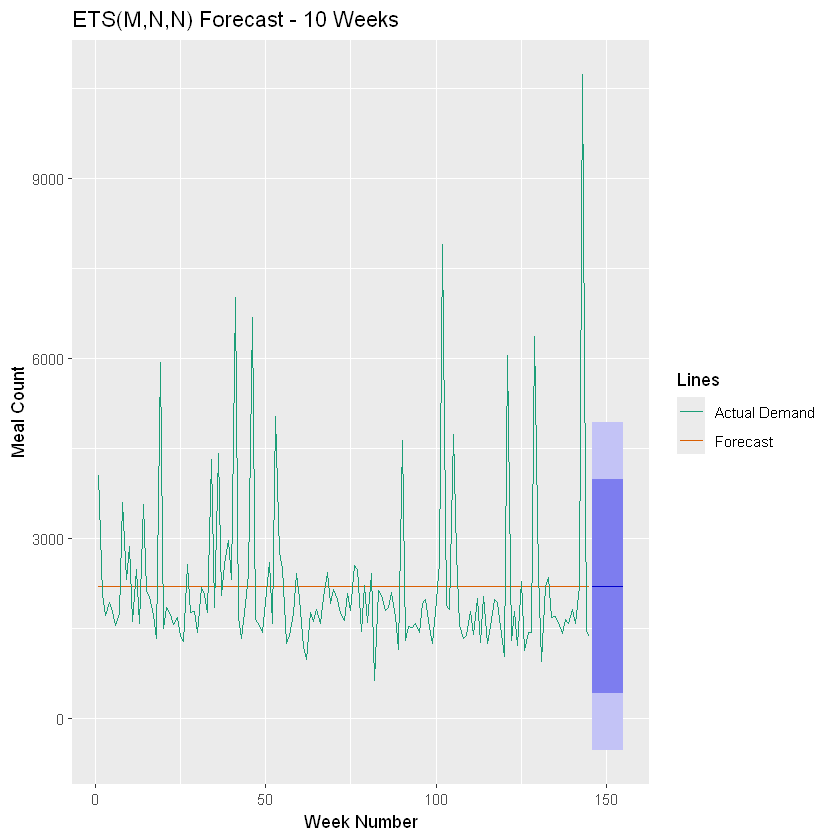

In [43]:
# Create Model
meal_ets = ets(df_2$num_orders)


# Forecasts out 10 weeks by default (h=10)
autoplot(forecast(meal_ets))+
  labs(title = "ETS(M,N,N) Forecast - 10 Weeks",
       x = "Week Number",
       y = "Meal Count",
       color = "Lines") +
  geom_line(aes(x = time(meal_ets$fitted), y=meal_ets$fitted, color = "Forecast")) +
  geom_line(aes(x = time(meal_ets$x), y=meal_ets$x, color = "Actual Demand")) +
  scale_color_brewer(palette = "Dark2", name = "Lines")
  
summary(meal_ets)

test_2 = filter(test, test$meal_id == 2290 & test$center_id == 13)


	Ljung-Box test

data:  Residuals from ETS(A,N,N)
Q* = 4.8165, df = 10, p-value = 0.9031

Model df: 0.   Total lags used: 10




	Ljung-Box test

data:  Residuals from ETS(A,N,N)
Q* = 4.8165, df = 10, p-value = 0.9031


    Point Forecast    Lo 80    Hi 80     Lo 95    Hi 95
146       2204.817 420.8480 3988.787 -523.5283 4933.163
147       2204.817 420.8479 3988.787 -523.5283 4933.163
148       2204.817 420.8479 3988.787 -523.5284 4933.163
149       2204.817 420.8479 3988.787 -523.5284 4933.163
150       2204.817 420.8479 3988.787 -523.5284 4933.163
151       2204.817 420.8479 3988.787 -523.5284 4933.163
152       2204.817 420.8479 3988.787 -523.5284 4933.163
153       2204.817 420.8479 3988.787 -523.5284 4933.163
154       2204.817 420.8479 3988.787 -523.5284 4933.163
155       2204.817 420.8479 3988.787 -523.5285 4933.163
156       2204.817 420.8479 3988.787 -523.5285 4933.163
157       2204.817 420.8479 3988.787 -523.5285 4933.163
158       2204.817 420.8478 3988.787 -523.5285 4933.163
159       2204.817 420.8478 3988.787 -523.5285 4933.163
160       2204.817 420.8478 3988.787 -523.5285 4933.163

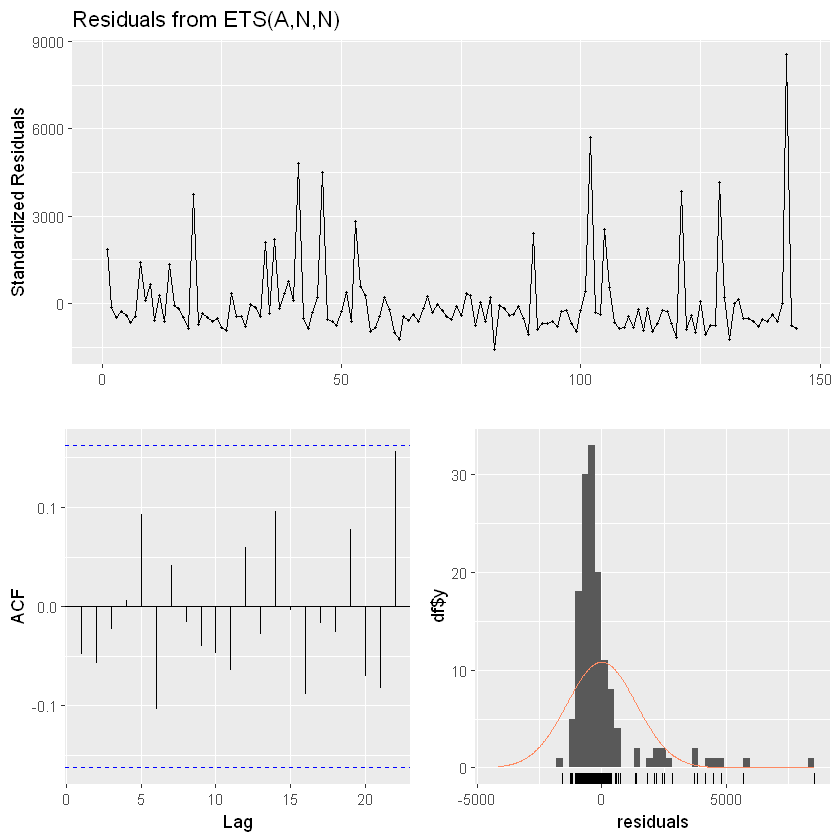

In [44]:
# Forecast out 15 weeks (h=15)

meal_ets_resid <- checkresiduals(meal_ets,
                  ylab = "Standardized Residuals")
meal_ets_resid

meal_ets_fore <- forecast(meal_ets, h=15)
meal_ets_fore 

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,-0.3244373,1382.405,812.7893,-20.981070,36.51008,0.7148019,-0.04874648
Test set,272.8494358,1506.228,623.3211,-2.550676,17.70523,0.5481754,NA


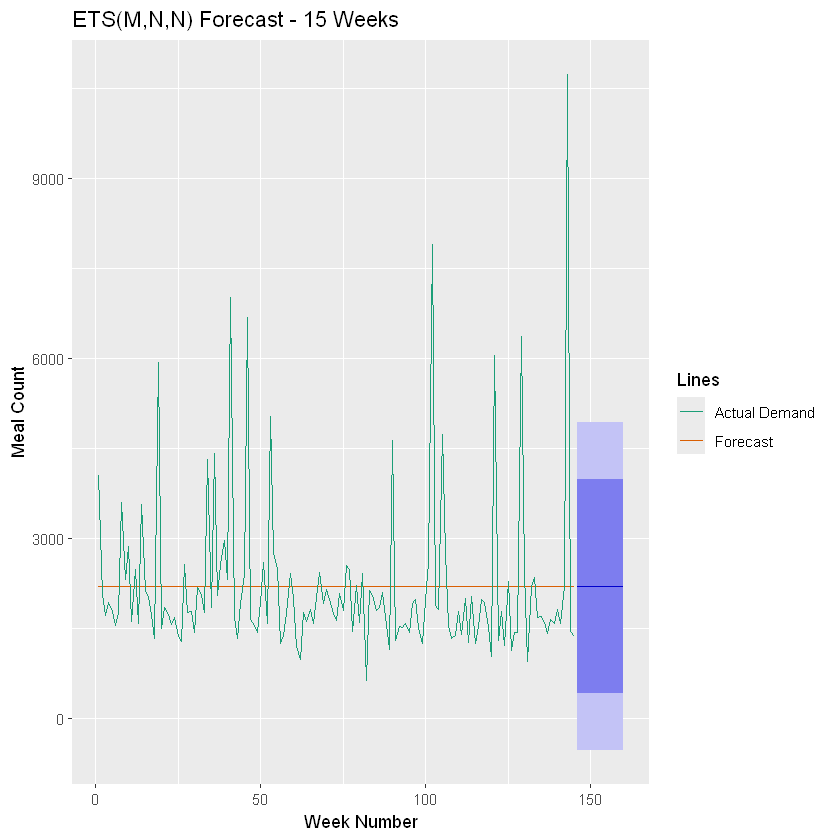

In [45]:
autoplot(meal_ets_fore) +
  labs(title = "ETS(M,N,N) Forecast - 15 Weeks",
       x = "Week Number",
       y = "Meal Count")+
  geom_line(aes(x = time(meal_ets$fitted), y=meal_ets$fitted, color = "Forecast")) +
  geom_line(aes(x = time(meal_ets$x), y=meal_ets$x, color = "Actual Demand")) +
  scale_color_brewer(palette = "Dark2", name = "Lines")


# Score
accuracy(meal_ets_fore, test_2$num_orders) 

## `SMA()` - Simple Moving Average

,ME,RMSE,MAE,MPE,MAPE
Test set,-65.08333,307.7345,179.65,-5.051084,10.06524


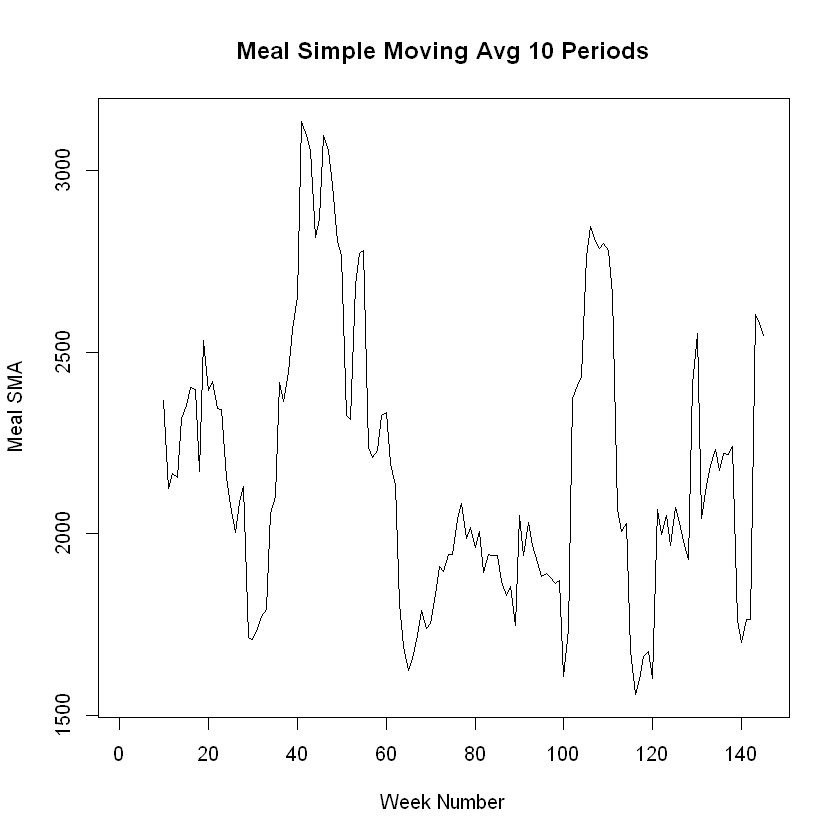

In [48]:
# Create Model. n is the number of periods to average over
meal_sma = SMA(df_2$num_orders, n=10)

# Plot
plot.ts(meal_sma, 
        main= "Meal Simple Moving Avg 10 Periods",
        xlab = "Week Number",
        ylab = "Meal SMA")
# Score
accuracy(meal_sma, test_2$num_orders)


## ARIMA:


Now we will compare different functions for time series forecasting:

## SES() - useful for data w/ no trend or seasonality

Series: df_2$num_orders 
ARIMA(0,0,0) with non-zero mean 

Coefficients:
           mean
      2204.6621
s.e.   114.7968

sigma^2 = 1924122:  log likelihood = -1254.32
AIC=2512.64   AICc=2512.72   BIC=2518.59


Call:
arima(x = df_2$num_orders, order = c(0, 0, 2))

Coefficients:
          ma1      ma2  intercept
      -0.0541  -0.0583  2203.7378
s.e.   0.0831   0.0825   101.7145

sigma^2 estimated as 1898927:  log likelihood = -1253.87,  aic = 2515.74

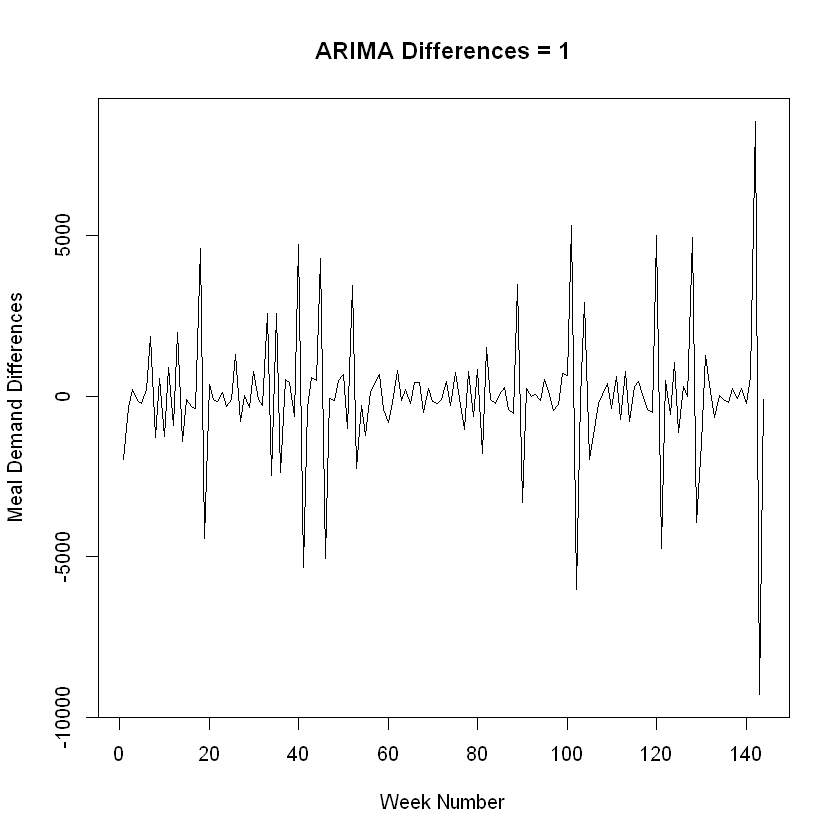

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,1.391541,1378.015,810.9294,-20.729890,36.34673,0.7131662,0.0008767045
Test set,270.113610,1506.395,622.2240,-2.673425,17.66490,0.5472105,NA


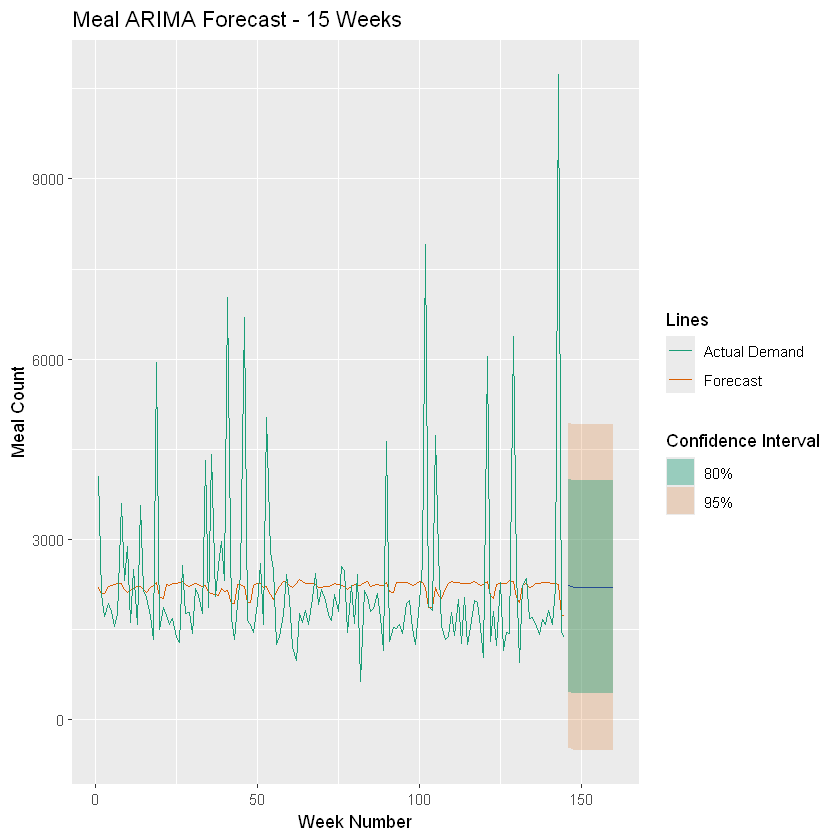

In [51]:
# Create model with differences
meal_ar_diff = diff(df_2$num_orders, differences = 1)

# Plot
plot.ts(meal_ar_diff, main = "ARIMA Differences = 1",
        xlab = 'Week Number',
        ylab = "Meal Demand Differences")

# Create model with auto.arima()
meal_auto = auto.arima(df_2$num_orders) 
meal_auto

# Create arima model 0,0,2 from auto.arima optimizer
meal_arima = arima(df_2$num_orders, order = c(0,0,2))
meal_arima
# Forecast out 15 weeks
meal_arima_for = forecast(meal_arima, h=15)

# Plot Arima
plot_forecast(meal_arima_for, "Meal ARIMA Forecast - 15 Weeks")
# Score
accuracy(meal_arima_for, test_2$num_orders)